In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import os.path
import glob

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization

import cv2
from tqdm import tqdm

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import fbeta_score
import time
from matplotlib import pyplot as plt

%matplotlib inline

Using TensorFlow backend.
/home/chicm/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
DATA_DIR = '/home/chicm/data/planet'
RESULT_DIR = DATA_DIR + '/resultsv2'


df_train = pd.read_csv(DATA_DIR+'/train_v2.csv')
df_test = pd.read_csv(DATA_DIR+'/sample_submission_v2.csv')

classes = ['clear', 'haze', 'partly_cloudy', 'cloudy', 
           'primary', 'agriculture', 'water', 'cultivation', 'habitation', 'road',
            'slash_burn', 'conventional_mine', 'bare_ground', 'artisinal_mine', 
           'blooming', 'selective_logging', 'blow_down']

In [3]:
flatten = lambda l:[item for sublist in l for item in sublist]
t = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))
print(t)

['artisinal_mine', 'blooming', 'blow_down', 'cultivation', 'road', 'primary', 'cloudy', 'water', 'partly_cloudy', 'bare_ground', 'clear', 'habitation', 'slash_burn', 'haze', 'selective_logging', 'agriculture', 'conventional_mine']


In [4]:
label_map = {l: i for i, l in enumerate(classes)}
inv_label_map = {i: l for l, i in label_map.items()}
print(inv_label_map)

{0: 'clear', 1: 'haze', 2: 'partly_cloudy', 3: 'cloudy', 4: 'primary', 5: 'agriculture', 6: 'water', 7: 'cultivation', 8: 'habitation', 9: 'road', 10: 'slash_burn', 11: 'conventional_mine', 12: 'bare_ground', 13: 'artisinal_mine', 14: 'blooming', 15: 'selective_logging', 16: 'blow_down'}


In [5]:
img_size = (224, 224)
x_train_list = []
y_train_list = []

for f, tags in tqdm(df_train.values, miniters=10000):
    fn = DATA_DIR+'/train-jpg/'+f+'.jpg'
    img = cv2.imread(fn) 
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train_list.append(cv2.resize(img, img_size)) 
    y_train_list.append(targets)
    


100%|██████████| 40479/40479 [00:53<00:00, 760.36it/s]


In [6]:
x_train = np.array(x_train_list)
y_train = np.array(y_train_list)
print(x_train.shape) 
print(y_train.shape)

(40479, 224, 224, 3)
(40479, 17)


In [7]:
del x_train_list
del y_train_list

In [8]:
print(df_train[:5])
print(y_train[:5])

  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road
[[ 0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.]]


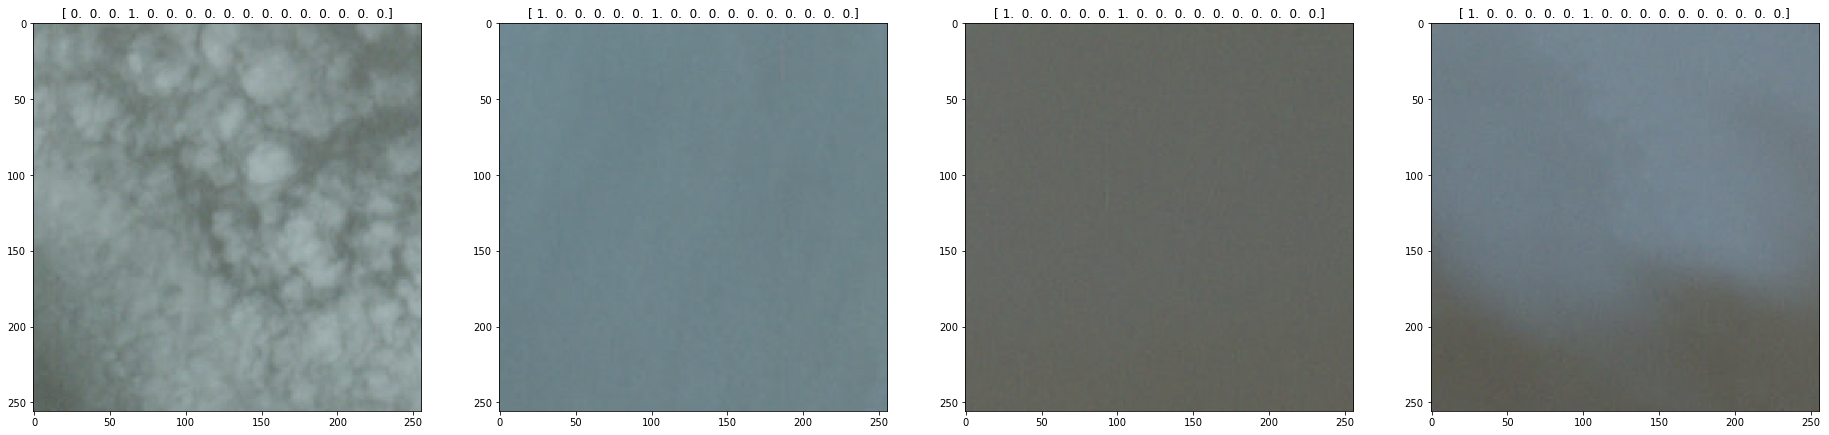

In [8]:
plt.figure(figsize=(32,32))
plt.subplot(1,4,1)
plt.imshow(x_train[26])
plt.title(y_train[26])
plt.subplot(1,4,2)
plt.imshow(x_train[273])
plt.title(y_train[273])
plt.subplot(1,4,3)
plt.imshow(x_train[290])
plt.title(y_train[290])
plt.subplot(1,4,4)
plt.imshow(x_train[412])
plt.title(y_train[412])

# Split training data

In [9]:
split_percent = 0.85
split = int(x_train.shape[0] * split_percent)
x_val = x_train[split:]
y_val = y_train[split:]
x_train = x_train[:split]
y_train = y_train[:split]

print(x_val.shape, y_val.shape, x_train.shape, y_train.shape)

(6072, 224, 224, 3) (6072, 17) (34407, 224, 224, 3) (34407, 17)


In [10]:
print(np.mean(x_train))

81.7656678181


# Data augumentation

In [11]:
batch_size=16

In [12]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        width_shift_range=0.05,
        height_shift_range=0.05, 
        horizontal_flip=True,
        vertical_flip = True,
        rescale = 1./255)

In [13]:
test_datagen = ImageDataGenerator(
        rescale = 1./255)


# Create Model

In [14]:
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Activation

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras import backend as K

In [15]:
from keras import applications
res50 = applications.ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3))

In [16]:
def get_fc_model(input_shape):
    fc_model = Sequential()
    fc_model.add(Flatten(input_shape=input_shape))
    #fc_model.add(Dense(256, activation='relu'))
    #fc_model.add(Dropout(0.6))
    fc_model.add(Dense(17, activation='sigmoid'))
    return fc_model

In [17]:
model = Model(inputs=res50.input, outputs=get_fc_model(res50.output_shape[1:])(res50.output))

In [18]:
model.compile(loss='binary_crossentropy', 
                      optimizer='adam',
                      metrics=['accuracy'])

# Train model

In [22]:
from keras.callbacks import LearningRateScheduler
def lr_schedule(epoch):
    if epoch <= 10:
        return 0.001
    elif epoch <= 20:
        return 0.0001
    else: 
        return 0.00005
    
w_filename = RESULT_DIR + '/res50_224.h5'
callbacks = [ EarlyStopping(monitor='val_loss', patience=40, verbose=0),
              ModelCheckpoint(w_filename, monitor='val_loss', save_best_only=True, verbose=0),
              LearningRateScheduler(lr_schedule)]

In [23]:
epochs = 100

In [24]:
model.fit_generator(
        train_datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=x_train.shape[0] // batch_size,
        epochs=epochs,
        validation_data=test_datagen.flow(x_val, y_val, batch_size=batch_size), 
        validation_steps=x_val.shape[0] // batch_size,
        verbose=2,
        callbacks=callbacks)

Epoch 1/100
493s - loss: 0.1483 - acc: 0.9429 - val_loss: 0.1304 - val_acc: 0.9483
Epoch 2/100
468s - loss: 0.1197 - acc: 0.9539 - val_loss: 0.2921 - val_acc: 0.9172
Epoch 3/100
468s - loss: 0.1116 - acc: 0.9573 - val_loss: 0.1568 - val_acc: 0.9359
Epoch 4/100
468s - loss: 0.1070 - acc: 0.9588 - val_loss: 0.1557 - val_acc: 0.9375
Epoch 5/100
469s - loss: 0.1036 - acc: 0.9601 - val_loss: 0.1599 - val_acc: 0.9365
Epoch 6/100
469s - loss: 0.1011 - acc: 0.9610 - val_loss: 0.1760 - val_acc: 0.9274
Epoch 7/100
470s - loss: 0.0987 - acc: 0.9620 - val_loss: 0.1282 - val_acc: 0.9477
Epoch 8/100
469s - loss: 0.0968 - acc: 0.9624 - val_loss: 0.2690 - val_acc: 0.8961
Epoch 9/100
502s - loss: 0.0953 - acc: 0.9631 - val_loss: 0.2329 - val_acc: 0.9221
Epoch 10/100
505s - loss: 0.0941 - acc: 0.9635 - val_loss: 0.3194 - val_acc: 0.8909
Epoch 11/100
506s - loss: 0.0932 - acc: 0.9638 - val_loss: 0.1475 - val_acc: 0.9420
Epoch 12/100
495s - loss: 0.0855 - acc: 0.9665 - val_loss: 0.0853 - val_acc: 0.9671
E

# Find best thresholds

In [26]:
model.load_weights(w_filename)

In [30]:
print(np.max(x_val))

255


In [31]:
x_val = x_val / 255.

In [32]:
print(np.mean(x_val))

0.319779734174


In [33]:
pred_val = model.predict(x_val, batch_size=batch_size, verbose=2)

In [35]:
print(pred_val[:5])

[[  9.99858499e-01   2.93157300e-05   7.23574922e-05   1.17544579e-08
    9.99998331e-01   1.88213843e-03   6.66980981e-04   3.63010622e-04
    4.47272649e-03   3.47845198e-04   3.45748918e-09   1.20959286e-13
    1.48884747e-05   2.49554229e-13   4.61414037e-03   4.72017302e-04
    2.39206725e-04]
 [  5.25961723e-03   2.16855407e-02   5.90177224e-05   9.70001519e-01
    3.32388021e-02   4.76877118e-04   5.30947978e-03   3.14057761e-05
    3.90282803e-05   4.53111425e-04   4.75164010e-17   2.22561022e-20
    5.59842706e-09   2.99019740e-14   3.03582419e-19   7.80039755e-18
    1.20124280e-16]
 [  9.99868631e-01   7.19455193e-06   1.20634577e-04   5.67238478e-10
    9.99999166e-01   2.69926153e-03   7.24922458e-04   4.62576427e-04
    7.73407752e-04   7.83959695e-04   8.11005396e-09   4.94620458e-13
    1.32469304e-05   4.76361843e-13   2.35142233e-03   5.95939055e-04
    1.19775638e-03]
 [  9.98425722e-01   1.87370650e-04   5.06852579e-04   4.28398961e-09
    9.99890924e-01   9.0942448

In [37]:
def optimise_f2_thresholds(y, p, verbose=True, resolution=100):
    def mf(x):
        p2 = np.zeros_like(p)
        for i in range(17):
            p2[:, i] = (p[:, i] > x[i]).astype(np.int)
        score = fbeta_score(y, p2, beta=2, average='samples')
        return score

    x = [0.18] * 17
    for i in range(17):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            i2 /= resolution
            x[i] = i2
            score = mf(x)
            if score > best_score:
                best_i2 = i2
                best_score = score
        x[i] = best_i2
        if verbose:
            print(i, best_i2, best_score)

    for i in range(17):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            i2 /= resolution
            x[i] = i2
            score = mf(x)
            if score > best_score:
                best_i2 = i2
                best_score = score
        x[i] = best_i2
        if verbose:
            print(i, best_i2, best_score)
            
    return x

In [38]:
thr = optimise_f2_thresholds(y_val, pred_val)

0 0.2 0.927211707958
1 0.18 0.927211707958
2 0.12 0.927365249266


/home/chicm/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


3 0.09 0.928399798706
4 0.31 0.928768080386
5 0.13 0.928802288443
6 0.18 0.928802288443
7 0.26 0.929088996515
8 0.26 0.929340602807
9 0.21 0.929415288289
10 0.32 0.929506310529
11 0.28 0.929530959567
12 0.18 0.929530959567
13 0.16 0.929575892269
14 0.24 0.92968291064
15 0.19 0.929725100231
16 0.33 0.929759098814
0 0.2 0.929759098814
1 0.25 0.929799788434
2 0.12 0.929799788434
3 0.09 0.929799788434
4 0.31 0.929799788434
5 0.13 0.929799788434
6 0.18 0.929799788434
7 0.26 0.929799788434
8 0.26 0.929799788434
9 0.21 0.929799788434
10 0.32 0.929799788434
11 0.28 0.929799788434
12 0.18 0.929799788434
13 0.16 0.929799788434
14 0.24 0.929799788434
15 0.19 0.929799788434
16 0.33 0.929799788434


In [39]:
print(thr)

[0.2, 0.25, 0.12, 0.09, 0.31, 0.13, 0.18, 0.26, 0.26, 0.21, 0.32, 0.28, 0.18, 0.16, 0.24, 0.19, 0.33]


In [11]:
thr = [0.2, 0.25, 0.12, 0.09, 0.31, 0.13, 0.18, 0.26, 0.26, 0.21, 0.32, 0.28, 0.18, 0.16, 0.24, 0.19, 0.33]

# Make submission

In [27]:
import bcolz
import glob

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]


In [32]:
df_test = pd.read_csv(DATA_DIR+'/sample_submission_v2.csv')

In [33]:
preds = np.zeros((df_test.values.shape[0], 17))
index = 0
for f, tags in tqdm(df_test.values):
    fn = DATA_DIR+'/test-jpg/'+f+'.jpg'
    if not os.path.isfile(fn):
        fn = DATA_DIR+'/test-jpg-add/'+f+'.jpg'
    img = cv2.imread(fn)
    #x_test.append(cv2.resize(img, img_size))
    #x_test[index] = img / 255.
    img = img/255.
    x_test = np.expand_dims(img, axis=0)
    preds[index] = model.predict(x_test)
    index += 1


100%|██████████| 61191/61191 [17:03<00:00, 59.79it/s]


In [30]:
print(preds.shape)

(61191, 17)


In [34]:
save_array(RESULT_DIR+'/preds.dat', preds)

In [35]:
print(preds[:5])

[[  9.98107076e-01   2.44011031e-03   5.99584419e-05   1.28415536e-07
    9.99978662e-01   2.97449925e-03   2.20675021e-03   1.14945986e-03
    2.19779578e-03   9.84876882e-04   2.00360930e-07   6.58251058e-12
    7.10248278e-05   1.66358930e-12   1.98746342e-02   1.35715178e-03
    8.27464275e-04]
 [  9.97804821e-01   2.37056684e-05   2.92682229e-03   6.81408430e-10
    9.99999642e-01   5.46942512e-03   4.40920761e-04   1.21302262e-03
    4.43664001e-04   4.09760221e-04   9.67624114e-09   1.21644136e-13
    1.23169420e-05   5.67540589e-13   1.85405975e-03   3.93186900e-04
    9.14004282e-04]
 [  4.69667975e-06   9.87952603e-07   9.99735653e-01   1.54740574e-05
    9.99983191e-01   1.26873711e-02   4.98612262e-02   4.37710294e-03
    8.44378883e-05   7.02132331e-03   1.57957595e-06   6.71198375e-11
    2.86169161e-05   2.83954166e-10   1.82413942e-08   3.70630232e-06
    1.37054678e-06]
 [  8.63901854e-01   1.41512661e-03   1.51743889e-01   1.84250428e-08
    9.99996066e-01   4.7112157

In [36]:
def get_multi_classes(score, threshold, nil=''):
    N = len(classes)
    s = nil
    for n in range(N):
        if score[n] > threshold[n]:
            if s == nil:
                s = classes[n]
            else:
                s = '%s %s' % (s, classes[n])
    return s

In [37]:
for i, pred in enumerate(preds):
    tags = get_multi_classes(pred, thr)
    df_test['tags'][i] = tags



In [38]:
df_test.to_csv(RESULT_DIR+'/sub1.csv', index=False)

In [20]:
print(thr)

[0.2, 0.25, 0.12, 0.09, 0.31, 0.13, 0.18, 0.26, 0.26, 0.21, 0.32, 0.28, 0.18, 0.16, 0.24, 0.19, 0.33]


In [41]:
nfolds = 6
batch_size = 128

num_fold = 0
sum_score = 0

kf = KFold(len(y_train), n_folds=nfolds, shuffle=True, random_state=1)

for train_index, test_index in kf:
        start_time_model_fitting = time.time()
        
        X_train = x_train[train_index]
        Y_train = y_train[train_index]
        X_valid = x_train[test_index]
        Y_valid = y_train[test_index]

        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        print('Split train: ', len(X_train), len(Y_train))
        print('Split valid: ', len(X_valid), len(Y_valid))
        
        w_filename = RESULT_DIR + '/wconv_' + str(num_fold) + '.h5'
        
        model = get_model()
        
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, verbose=0),
            ModelCheckpoint(w_filename, monitor='val_loss', save_best_only=True, verbose=0)]
        
        model.fit(x = X_train, y= Y_train, validation_data=(X_valid, Y_valid),
                  batch_size=batch_size,verbose=2, epochs=5, shuffle=True)
        
        K.set_value(model.optimizer.lr, 0.00001)
        
        model.fit(x = X_train, y= Y_train, validation_data=(X_valid, Y_valid),
                  batch_size=batch_size, verbose=2, epochs=80, shuffle=True, callbacks = callbacks)
        
        
        p_valid = model.predict(X_valid, batch_size = batch_size, verbose=2)
        print(fbeta_score(Y_valid, np.array(p_valid) > 0.18, beta=2, average='samples'))
        
        

Start KFold number 1 from 6
Split train:  33732 33732
Split valid:  6747 6747
Train on 33732 samples, validate on 6747 samples
Epoch 1/5
38s - loss: 0.4670 - acc: 0.8167 - val_loss: 0.2817 - val_acc: 0.9106
Epoch 2/5
31s - loss: 0.1969 - acc: 0.9301 - val_loss: 0.3107 - val_acc: 0.9103
Epoch 3/5
32s - loss: 0.1698 - acc: 0.9366 - val_loss: 0.5406 - val_acc: 0.8727
Epoch 4/5
32s - loss: 0.1580 - acc: 0.9400 - val_loss: 0.1603 - val_acc: 0.9366
Epoch 5/5
32s - loss: 0.1482 - acc: 0.9429 - val_loss: 0.1928 - val_acc: 0.9250
Train on 33732 samples, validate on 6747 samples
Epoch 1/80
36s - loss: 0.1416 - acc: 0.9455 - val_loss: 0.1338 - val_acc: 0.9471
Epoch 2/80
32s - loss: 0.1394 - acc: 0.9460 - val_loss: 0.1316 - val_acc: 0.9484
Epoch 3/80
32s - loss: 0.1388 - acc: 0.9465 - val_loss: 0.1307 - val_acc: 0.9484
Epoch 4/80
32s - loss: 0.1380 - acc: 0.9466 - val_loss: 0.1313 - val_acc: 0.9478
Epoch 5/80
32s - loss: 0.1368 - acc: 0.9470 - val_loss: 0.1302 - val_acc: 0.9488
Epoch 6/80
32s - lo

## ensemble

In [46]:
import bcolz
import glob

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]


PREDICTS_FILE = RESULT_DIR + '/preds'

def ensemble():
    preds = []
    w_files = glob.glob(RESULT_DIR +'/wconv_*.h5')
    for fn in w_files:
        model = get_model()
        print(fn)
        model.load_weights(fn)
        preds.append(model.predict(x_test, batch_size=128))
    m = np.mean(preds, axis=0)
    print(m.shape)
    save_array(PREDICTS_FILE, m)
    return m

In [47]:
result = ensemble()

result = pd.DataFrame(result, columns = labels)
result

/home/chicm/data/planet/resultsv2/wconv_5.h5
/home/chicm/data/planet/resultsv2/wconv_3.h5
/home/chicm/data/planet/resultsv2/wconv_4.h5
/home/chicm/data/planet/resultsv2/wconv_2.h5
/home/chicm/data/planet/resultsv2/wconv_6.h5
/home/chicm/data/planet/resultsv2/wconv_1.h5
(61191, 17)


,haze,cultivation,blooming,partly_cloudy,habitation,primary,road,agriculture,selective_logging,artisinal_mine,slash_burn,blow_down,cloudy,bare_ground,conventional_mine,clear,water
0,0.002282,0.001152,0.007417,0.000157,0.000439,0.999537,0.001956,0.002205,0.000570,0.000054,0.000096,0.000445,0.000285,0.000360,0.000035,0.999130,0.006381
1,0.000715,0.003500,0.012611,0.001527,0.000834,0.999433,0.003365,0.004024,0.001773,0.000121,0.000178,0.000813,0.000473,0.000362,0.000058,0.998265,0.010875
2,0.000020,0.008655,0.000013,0.999564,0.000539,0.998762,0.008366,0.039851,0.000012,0.000013,0.000016,0.000012,0.000703,0.000042,0.000003,0.000066,0.036886
3,0.001383,0.007506,0.007806,0.007181,0.001555,0.998597,0.006056,0.011330,0.001824,0.000164,0.000290,0.000800,0.000883,0.000760,0.000085,0.990166,0.017417
4,0.002283,0.001846,0.000082,0.501018,0.000938,0.436492,0.008180,0.018032,0.000045,0.000060,0.000022,0.000037,0.550392,0.000225,0.000045,0.001707,0.034938
5,0.000326,0.000598,0.002263,0.000087,0.000161,0.999666,0.000807,0.001365,0.000165,0.000008,0.000026,0.000139,0.000234,0.000090,0.000006,0.999535,0.002520
6,0.085211,0.220040,0.001899,0.254308,0.139351,0.988512,0.312776,0.608390,0.005095,0.003962,0.004658,0.001481,0.004334,0.023026,0.001650,0.643094,0.405633
7,0.002256,0.010192,0.000101,0.001455,0.887690,0.815533,0.951758,0.225530,0.000574,0.004287,0.000098,0.000072,0.002508,0.012728,0.000894,0.993042,0.126930
8,0.000587,0.001203,0.004099,0.000170,0.000498,0.999521,0.002168,0.002402,0.000457,0.000037,0.000065,0.000277,0.000250,0.000262,0.000022,0.999461,0.005090
9,0.876548,0.042462,0.000698,0.010119,0.010125,0.985020,0.054970,0.158937,0.000601,0.000378,0.000880,0.000701,0.008518,0.003040,0.000350,0.219986,0.115348


In [48]:
from tqdm import tqdm

preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > 0.18, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [01:36<00:00, 635.99it/s]


In [49]:
df_test['tags'] = preds
df_test

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,partly_cloudy primary
3,test_3,primary clear
4,test_4,partly_cloudy primary cloudy
5,test_5,primary clear
6,test_6,cultivation partly_cloudy primary road agricul...
7,test_7,habitation primary road agriculture clear
8,test_8,primary clear
9,test_9,haze primary clear


In [50]:
df_test.to_csv(RESULT_DIR+'/v2_sub2.csv', index=False)

In [30]:
%pwd


'/home/chicm/ml/planet'